# Analysis of Human Kidney Immunne (Lupus Nephritis vs. Healthy control)

## Data source: E-MTAB-13596

## **ScRNA-seq of human kidney immune cells of patients with ANCA-associated glomerulonephritis, Lupus Nephritis against a healthy nephrectomy control**

### "ANCA-associated glomerulonephritis (AGN) associates with a high risk of end-stage kidneydisease. The role of kidney immune cells in local inflammation remains unclear. Herewe investigate kidney immune cell diversity and function. Kidney tissue from AGN patients (n=5) and a lupus nephritis (LN) patient (n=1) were aquired during a biopsy procedure for a clinical indication. Needle-core biopsies were obtained for histopathological examination, and an additional pass was performed to retrieve kidney tissue for scRNA-seq. Healthy kidney tissue (n=1) was obtained from a kidney that was surgically removed do tue due to a (non-invasive) papillary urothelial carcinoma. Immediately after collection, kidney tissue was processed into a single-cell suspension and sorted using a 4-color flow cytometry panel to isolate living, CD45+immune cells. To aid in the multi-omic characterization, surface markers and T and B cell repertoires were sequenced in 2 samples (1 AGN patient and the nephrectomy control). These samples were incubated with an oligo-antibody TotalSeq-C cocktail containing 130 unique cell surface antigens."

In [1]:
PDIR = '/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/'

# Convert raw data to AnnData object

## Parse metadata

In [2]:
# --- Parse SDRF metadata ---
import pandas as pd
import os
# Use the flat file location, which exists
sdrf_path = f"{PDIR}/lupus-emtab/raw-data/E-MTAB-13596.sdrf.txt"
print("Parsing SDRF metadata from:", sdrf_path)
sdrf = pd.read_csv(sdrf_path, sep="\t")

# Extract relevant columns and sample file info
samples = []
for idx, row in sdrf.iterrows():
    sample_id = row["Source Name"]
    disease = row["Characteristics[disease]"]
    cell_type = row["Characteristics[cell type]"]
    disease_stage = row.get("Characteristics[disease staging]", "")
    # Use the correct columns for file names
    matrix_file = row.get("Protocol REF.44", None)
    barcode_file = row.get("Protocol REF.42", None)
    feature_file = row.get("Protocol REF.43", None)
    # Fallback: infer from sample_id
    if not isinstance(matrix_file, str) or not matrix_file.endswith(".mtx"):
        matrix_file = f"{sample_id}_matrix.mtx"
    if not isinstance(barcode_file, str) or not barcode_file.endswith(".tsv"):
        barcode_file = f"{sample_id}_barcodes.tsv"
    if not isinstance(feature_file, str) or not feature_file.endswith(".tsv"):
        feature_file = f"{sample_id}_features.tsv"
    samples.append({
        "sample_id": sample_id,
        "disease": disease,
        "cell_type": cell_type,
        "disease_stage": disease_stage,
        "matrix_file": matrix_file,
        "barcode_file": barcode_file,
        "feature_file": feature_file,
    })

print(f"Found {len(samples)} samples in SDRF.")

Parsing SDRF metadata from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/E-MTAB-13596.sdrf.txt
Found 7 samples in SDRF.


## Load and annotate all samples

In [3]:
import scipy.io
from anndata.utils import make_index_unique
import pandas as pd
import scanpy as sc

adatas = []
for sample in samples:
    print(f"Loading sample {sample['sample_id']} ...")
    matrix_path = f"{PDIR}/lupus-emtab/raw-data/{sample['matrix_file']}"
    barcode_path = f"{PDIR}/lupus-emtab/raw-data/{sample['barcode_file']}"
    feature_path = f"{PDIR}/lupus-emtab/raw-data/{sample['feature_file']}"
    print(f"Loading matrix from: {matrix_path}")
    # Load matrix
    matrix = scipy.io.mmread(matrix_path)
    # Load barcodes
    barcodes = pd.read_csv(barcode_path, header=None)[0].tolist()
    # Load features
    features = pd.read_csv(feature_path, sep="\t", header=None)
    gene_names = features[1].tolist()  # column 1 is usually gene symbol
    # Check shape and transpose if needed
    if matrix.shape[0] == len(barcodes):
        matrix = matrix.tocsc()
    elif matrix.shape[1] == len(barcodes):
        matrix = matrix.T.tocsc()
    else:
        raise ValueError(f"Matrix dimensions {matrix.shape} do not match barcodes length {len(barcodes)} for sample {sample['sample_id']}.")
    # Diagnostic: check for unique barcodes
    prefixed_barcodes = [f"{sample['sample_id']}_" + bc for bc in barcodes]
    unique_barcodes = set(prefixed_barcodes)
    print(f"Sample {sample['sample_id']} - Total barcodes: {len(barcodes)}, Unique barcodes: {len(unique_barcodes)}")
    # Create AnnData
    ad = sc.AnnData(matrix)
    ad.obs_names = prefixed_barcodes
    ad.var_names = make_index_unique(pd.Index(gene_names))
    # Annotate sample metadata
    ad.obs["sample_id"] = sample["sample_id"]
    ad.obs["disease"] = sample["disease"]
    ad.obs["cell_type_sort"] = sample["cell_type"]
    ad.obs["disease_stage"] = sample["disease_stage"]
    ad.obs["batch"] = sample["sample_id"]
    adatas.append(ad)

print("Merging all samples into a single AnnData object...")
adata = adatas[0].concatenate(
    adatas[1:], batch_key="batch", batch_categories=[s["sample_id"] for s in samples]
)

print(f"Merged AnnData: {adata.n_obs} cells, {adata.n_vars} genes.")
print("AnnData .obs columns:", adata.obs.columns.tolist())
print("Preview of .obs (first 5 rows):")
print(adata.obs.head())

Loading sample AGN1 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN1_matrix.mtx
Sample AGN1 - Total barcodes: 6955, Unique barcodes: 6955
Loading sample AGN2 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN2_matrix.mtx
Sample AGN2 - Total barcodes: 3542, Unique barcodes: 3542
Loading sample AGN3 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN3_matrix.mtx
Sample AGN3 - Total barcodes: 5395, Unique barcodes: 5395
Loading sample AGN4 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN4_matrix.mtx
Sample AGN4 - Total barcodes: 1663, Unique barcodes: 1663
Loading sample AGN5 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN5_matrix.mtx
Sample AGN5 - Total bar

/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_7463/128507247.py:44: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(


Merged AnnData: 34993 cells, 20453 genes.
AnnData .obs columns: ['sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch']
Preview of .obs (first 5 rows):
                             sample_id  \
AGN1_AAACCCAAGCACCAGA-1-AGN1      AGN1   
AGN1_AAACCCAAGGACAAGA-1-AGN1      AGN1   
AGN1_AAACCCAAGTCACAGG-1-AGN1      AGN1   
AGN1_AAACCCAAGTGCGACA-1-AGN1      AGN1   
AGN1_AAACCCACAAGCCATT-1-AGN1      AGN1   

                                                                     disease  \
AGN1_AAACCCAAGCACCAGA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGGACAAGA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGTCACAGG-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGTGCGACA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCACAAGCCATT-1-AGN1  anti-neutrophil antibody associated vasculitis   

                                             cell_type_sort   disease_stage  \
AGN1_AAACCCAAGCACCAGA-

## Save AnnData object

In [4]:
# Preserve raw counts for downstream normalization
adata.raw = adata.copy()

In [5]:
# Save merged AnnData to .h5ad file in /input-data "lupus-emtab/input-data/lupus-emtab_merged.h5ad"
import os
output_dir = f"{PDIR}/lupus-emtab/input-data"
os.makedirs(output_dir, exist_ok=True)
adata.write_h5ad(os.path.join(output_dir, "lupus-emtab_merged.h5ad"))
print(f"Saved AnnData to {os.path.join(output_dir, 'lupus-emtab_merged.h5ad')}")

Saved AnnData to /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/input-data/lupus-emtab_merged.h5ad


# Data processing (Quality Control)

1. Load adata
2. scanpy zheng17 recipe
3. Harmony batch correction
4. UMAP
5. Save adata

In [6]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_merged.h5ad")

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:191: FutureWarning: Use sc.pl.highly_variable_genes instead
  ppp.filter_genes_dispersion(filter_result, log=True)


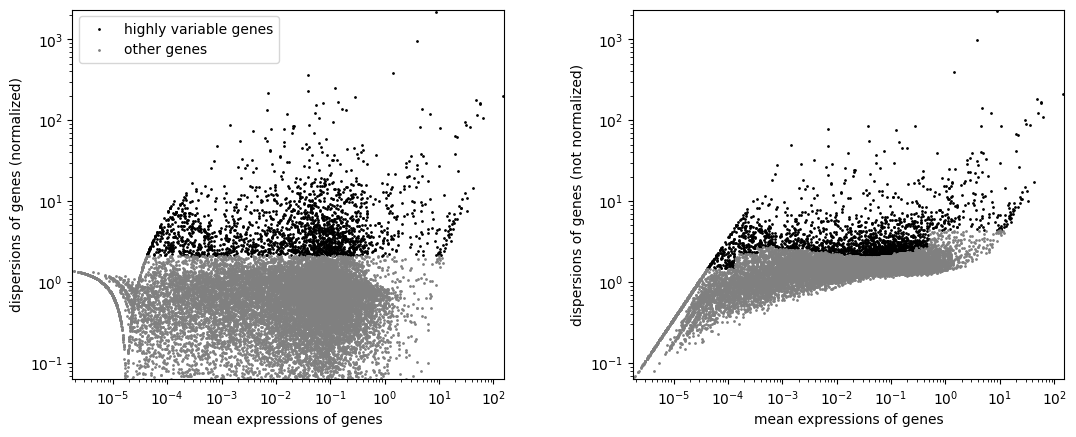

/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 34993 × 1999
    obs: 'sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch', 'n_counts_all'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p'

In [7]:
sc.pp.recipe_zheng17(
    adata,
    n_top_genes=2000,
    log = True,
    plot=True,
    copy=True
)

## Harmony batch correction

In [8]:
import scanpy.external as sce
import numpy as np

# PCA
sc.pp.pca(adata, n_comps=50, svd_solver='arpack')

print("Harmony will use 'batch' column for integration. Unique batch values:", adata.obs["batch"].unique())
sce.pp.harmony_integrate(adata, "batch")

if "X_pca_harmony" in adata.obsm:
    print("Harmony-corrected PCA found. Using for downstream analysis.")
    print("Shape of X_pca_harmony:", adata.obsm["X_pca_harmony"].shape)
    print("Any NaNs in X_pca_harmony?", np.isnan(adata.obsm["X_pca_harmony"]).any())
    print("Min/Max in X_pca_harmony:", adata.obsm["X_pca_harmony"].min(), adata.obsm["X_pca_harmony"].max())
    adata.obsm["X_pca"] = adata.obsm["X_pca_harmony"]
else:
    print("WARNING: Harmony-corrected PCA not found. Using default PCA.")

2026-02-06 13:30:25,358 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Harmony will use 'batch' column for integration. Unique batch values: ['AGN1', 'AGN2', 'AGN3', 'AGN4', 'AGN5', 'LN', 'NC']
Categories (7, object): ['AGN1', 'AGN2', 'AGN3', 'AGN4', 'AGN5', 'LN', 'NC']


2026-02-06 13:30:30,302 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-06 13:30:30,381 - harmonypy - INFO - Iteration 1 of 10
2026-02-06 13:30:34,706 - harmonypy - INFO - Iteration 2 of 10
2026-02-06 13:30:39,011 - harmonypy - INFO - Iteration 3 of 10
2026-02-06 13:30:43,263 - harmonypy - INFO - Converged after 3 iterations


Harmony-corrected PCA found. Using for downstream analysis.
Shape of X_pca_harmony: (34993, 50)
Any NaNs in X_pca_harmony? False
Min/Max in X_pca_harmony: -1587.936479518241 9173.128171497256


## Neighbors and UMAP on Harmony-corrected PCA

/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_7463/1327565348.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


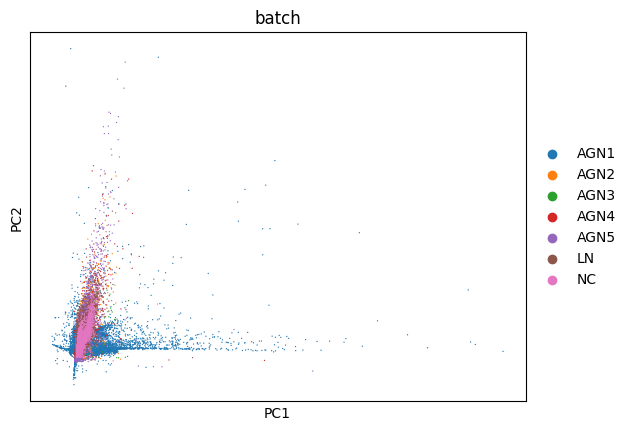

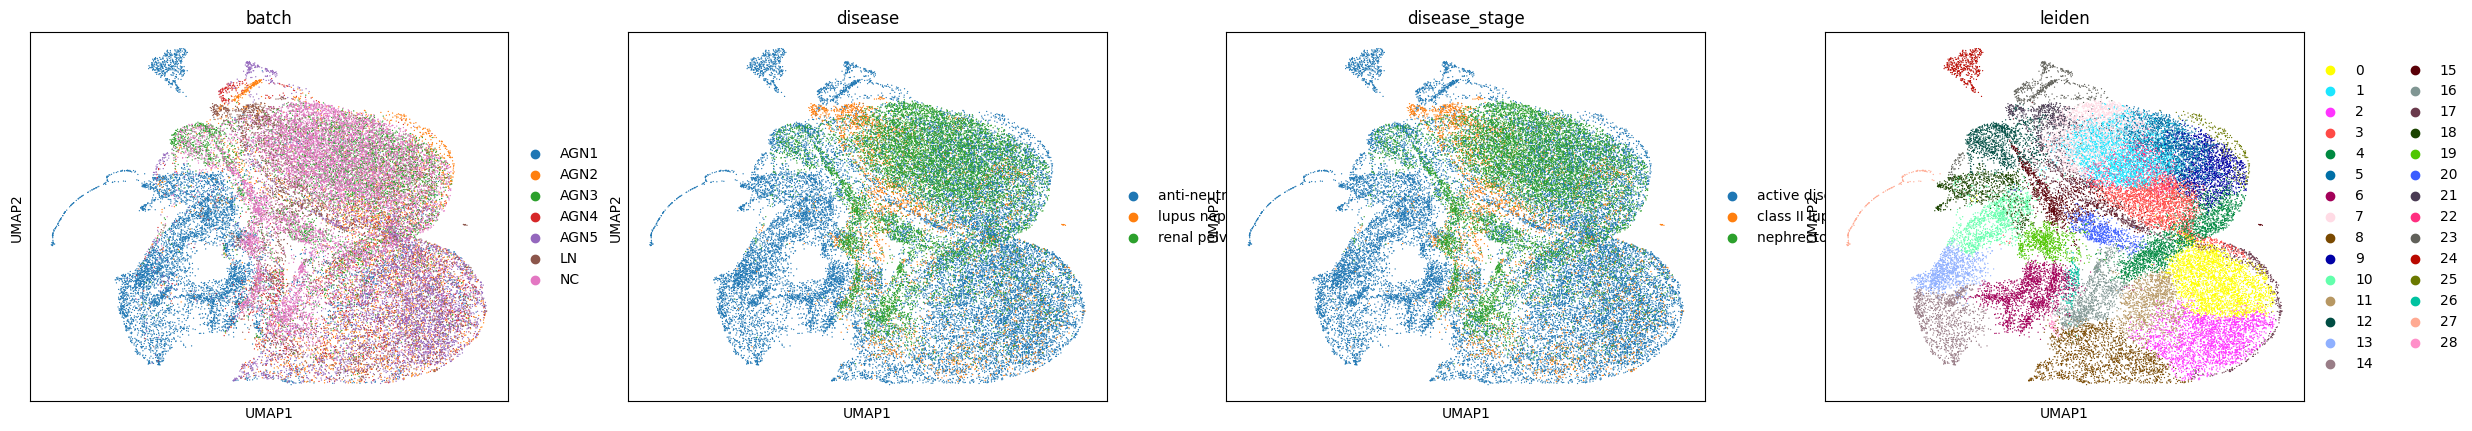

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Plots
sc.pl.pca(adata, color="batch")
sc.pl.umap(
    adata,
    color=["batch", "disease", "disease_stage", "leiden"]
)

## Save AnnData Object

In [10]:
adata.write_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

# Cell type annotation - CellTypist

In [11]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

In [12]:
import scanpy as sc
import numpy as np
import scipy.sparse

# Reset adata.X from adata.raw.X (raw counts)
if hasattr(adata, 'raw') and adata.raw is not None:
    if scipy.sparse.issparse(adata.raw.X):
        adata.X = adata.raw.X.toarray().copy()
    else:
        adata.X = adata.raw.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.X = np.nan_to_num(adata.X)
else:
    raise ValueError("AnnData.raw is missing; cannot reset adata.X for CellTypist.")

In [13]:
# CellTypist annotation pipeline (refactored for new data processing)
import celltypist
import mygene
from celltypist.models import Model
import numpy as np
import os
import pandas as pd
from anndata import AnnData

# Use processed AnnData (already log1p-normalized and batch-corrected)
# Map gene symbols to official gene symbols using mygene
mg = mygene.MyGeneInfo()
result = mg.querymany(list(adata.var.index), scopes="symbol", fields="symbol", species="human")
symbol_map = {r["query"]: r.get("symbol") for r in result if "symbol" in r}
valid_genes = [g for g in adata.var.index if g in symbol_map and symbol_map[g] is not None]
adata = adata[:, valid_genes]
adata.var_names = [symbol_map[g] for g in valid_genes]

# Aggregate duplicated gene symbols by sum
if len(set(adata.var_names)) < len(adata.var_names):
    df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names, index=adata.obs_names)
    df = df.groupby(df.columns, axis=1).sum()
    adata = AnnData(df.values, obs=adata.obs, var=pd.DataFrame(index=df.columns))

# Fill NaNs in .X with zeros
if np.isnan(adata.X).any():
    adata.X = np.nan_to_num(adata.X)

# CellTypist expects log1p-normalized data, so no further normalization needed
if adata.n_obs == 0 or adata.n_vars == 0:
    raise ValueError("AnnData is empty after gene mapping/aggregation.")

# Load or download CellTypist model
model_dir = os.path.expanduser("~/.celltypist/data/models")
model_path = os.path.join(model_dir, "Immune_All_Low.pkl")
if os.path.exists(model_path):
    model = Model.load(model_path)
else:
    model = celltypist.models.download_models("Immune_All_Low.pkl")

# Run CellTypist annotation
predictions = celltypist.annotate(adata, model=model, majority_voting=True)
if "majority_voting" in predictions.predicted_labels.columns:
    adata.obs["celltypist_label"] = predictions.predicted_labels["majority_voting"]
else:
    adata.obs["celltypist_label"] = predictions.predicted_labels.iloc[:, 0]

# Save cell type labels to CSV
os.makedirs(f"{PDIR}/lupus-emtab/outputs/", exist_ok=True)
adata.obs["celltypist_label"].to_csv(f"{PDIR}/lupus-emtab/outputs/celltypist_labels.csv")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-1000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 1001-2000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 2001-3000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 3001-4000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 4001-5000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 5001-6000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 6001-7000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 7001-8000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 8001-9000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 9001-10000 ...
HTTP Request: POS

## Check annotations

CellTypist label value counts:
celltypist_label
Tem/Trm cytotoxic T cells        9202
Epithelial cells                 5402
Tem/Temra cytotoxic T cells      4069
CD16+ NK cells                   3824
Non-classical monocytes          2707
Tem/Effector helper T cells      2382
Tcm/Naive helper T cells         2160
Classical monocytes              1723
DC2                              1160
Memory B cells                    517
Plasma cells                      445
Macrophages                       440
Naive B cells                     355
Regulatory T cells                319
Late erythroid                    148
Erythrophagocytic macrophages     102
DC1                                38
Name: count, dtype: int64


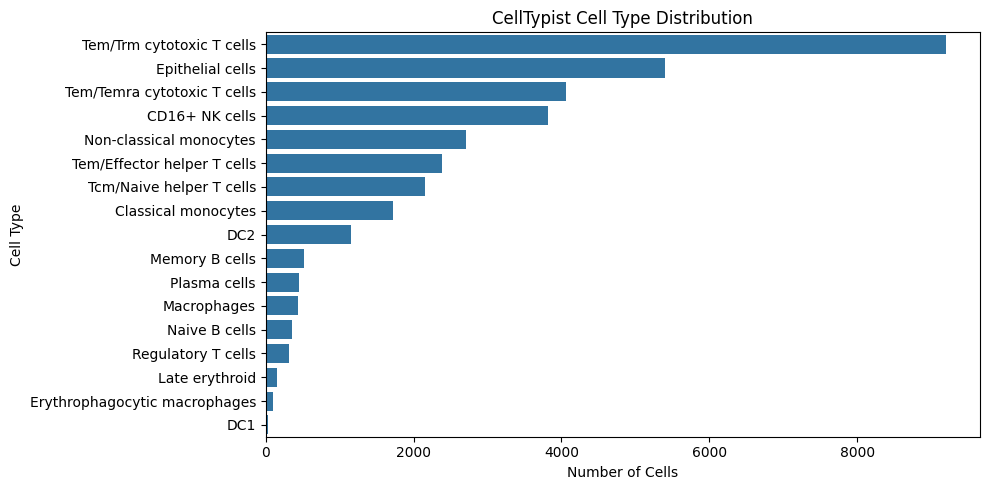


Cell type by disease:
disease                        anti-neutrophil antibody associated vasculitis  \
celltypist_label                                                                
CD16+ NK cells                                                           1833   
Classical monocytes                                                      1222   
DC1                                                                         6   
DC2                                                                       385   
Epithelial cells                                                         5335   
Erythrophagocytic macrophages                                              83   
Late erythroid                                                            148   
Macrophages                                                               417   
Memory B cells                                                            224   
Naive B cells                                                             188   
Non-c

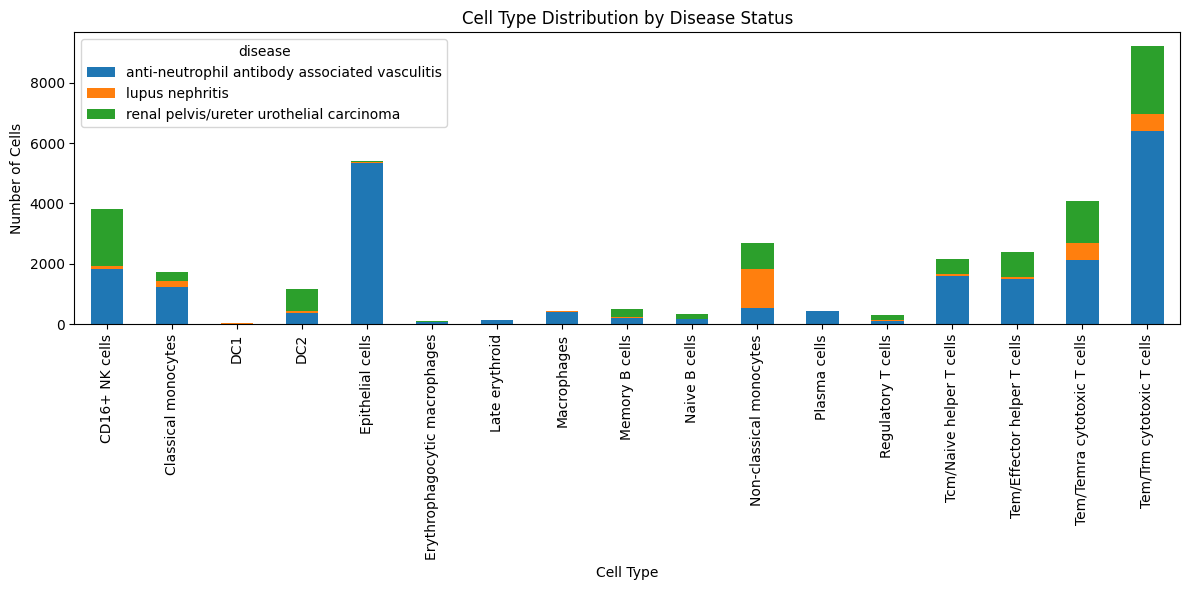

In [14]:
# Check CellTypist annotations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# View unique cell types and counts
print("CellTypist label value counts:")
print(adata.obs["celltypist_label"].value_counts())

# Plot cell type distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=adata.obs["celltypist_label"], order=adata.obs["celltypist_label"].value_counts().index)
plt.title("CellTypist Cell Type Distribution")
plt.xlabel("Number of Cells")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

# Cross-tabulate cell type by disease
if "disease" in adata.obs.columns:
    ctab = pd.crosstab(adata.obs["celltypist_label"], adata.obs["disease"])
    print("\nCell type by disease:")
    print(ctab)
    ctab.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Cell Type Distribution by Disease Status")
    plt.xlabel("Cell Type")
    plt.ylabel("Number of Cells")
    plt.tight_layout()
    plt.show()

## Save annotated AnnData object

In [15]:
# Save prepared AnnData object for Geneformer tokenization
adata.write_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_annotated.h5ad")

# Data exploration

In [16]:
import scanpy as sc

# adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_annotated.h5ad")

adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

In [17]:
adata

AnnData object with n_obs × n_vars = 34993 × 20453
    obs: 'sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch', 'leiden'
    uns: 'batch_colors', 'disease_colors', 'disease_stage_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [18]:
adata.obs

,sample_id,disease,cell_type_sort,disease_stage,batch,leiden
AGN1_AAACCCAAGCACCAGA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,13
AGN1_AAACCCAAGGACAAGA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,0
AGN1_AAACCCAAGTCACAGG-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,13
AGN1_AAACCCAAGTGCGACA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,14
AGN1_AAACCCACAAGCCATT-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,10
...,...,...,...,...,...,...
NC_TTTGTCATCATAACCG-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,15
NC_TTTGTCATCCGCAGTG-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,26
NC_TTTGTCATCCTCAACC-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,6
NC_TTTGTCATCTTCCTTC-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,7


In [19]:
adata.var

""
FAM138A
OR4F5
AL627309.1
OR4F29
OR4F16
...
AC011043.1
AL592183.1
AC011841.1
BX072566.1
